## Whole Genome Sequenced Mycobacterium bovis analysis for BTBgenie.

Note: the current version of the M.bovis genome online has genes missing in the annotation. See https://www.ncbi.nlm.nih.gov/nuccore/LT708304.1?report=graph

Updated files can be found here: https://github.com/dmnfarrell/gordon-group/tree/master/mbovis_annotation

links:

* https://github.com/JosephCrispell/GeneralTools/tree/master/ProcessingPipeline
* http://www.htslib.org/doc/bcftools.html


In [37]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
import pylab as plt
from Bio import SeqIO
from gzip import open as gzopen
sys.path.append('pathogenie')
from pathogenie import tools, aligners, app

### Examine FASTQ file quality and define trimming parameters

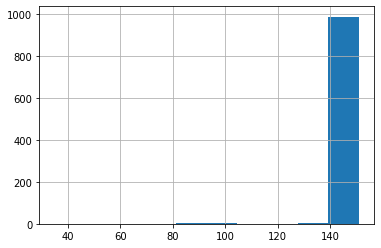

In [2]:
reload(tools)
testfile='albania/3_S57_L001-4_R1_001.fastq.gz'
df = tools.fastq_to_dataframe(testfile)
df.length.hist()

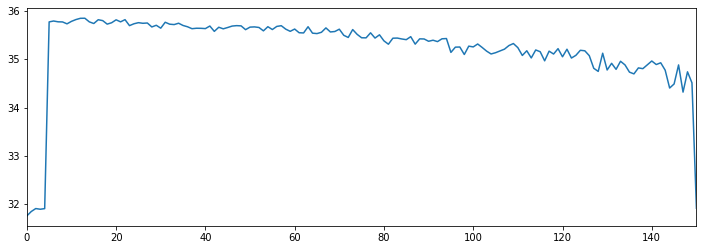

In [71]:
def plot_qualities(filename, ax=None):
    
    fastq_parser = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    res=[]
    c=0
    for record in fastq_parser:
        score=record.letter_annotations["phred_quality"]
        res.append(score)
        c+=1
        if c>1500:
            break
    df = pd.DataFrame(res)
    if ax==None:
        f,ax=plt.subplots(figsize=(12,4))
    df.mean().plot(ax=ax)
    return 

plot_qualities(testfile)

In [ ]:
reload(tools)
tools.trim_adapters(testfile, 'trimmed.fastq.gz')

### Get sample ids from fastq files

In [8]:
path='albania'
files = glob.glob(os.path.join(path,'*.fastq.gz'))
print (files)
from collections import defaultdict

def get_sample_names(filenames):
    """Get sample pairs from list of fastq files."""

    res = []
    cols = ['name','sample','filename']
    for filename in filenames:
        name = os.path.basename(filename).split('.')[0]
        sample = name.split('_R')[0]
        x = [name, sample, filename]
        res.append(x)

    df = pd.DataFrame(res, columns=cols)
    df = df.sort_values(['name','sample','pair']).reset_index(drop=True)
    df['pair'] = df.groupby('sample').cumcount()+1
    return df

df = get_sample_names(files)
df
#df.set_index(['sample','pair']).unstack()


['albania/6_S7_L001-4_R2_001.fastq.gz', 'albania/3_S57_L001-4_R1_001.fastq.gz', 'albania/6_S7_L001-4_R1_001.fastq.gz', 'albania/3_S57_L001-4_R2_001.fastq.gz']


,filename,name,sample,pair
0,albania/3_S57_L001-4_R1_001.fastq.gz,3_S57_L001-4_R1_001,3_S57_L001-4,1
1,albania/3_S57_L001-4_R2_001.fastq.gz,3_S57_L001-4_R2_001,3_S57_L001-4,2
2,albania/6_S7_L001-4_R1_001.fastq.gz,6_S7_L001-4_R1_001,6_S7_L001-4,1
3,albania/6_S7_L001-4_R2_001.fastq.gz,6_S7_L001-4_R2_001,6_S7_L001-4,2


### Align the FASTQ files against reference and create VCF files

In [31]:
reload(aligners)
path = 'albania'
ref = app.ref_genome

samples = get_sample_names(files)
def align_reads(samples, idx, outdir='mapped', callback=None, **kwargs):
    """
    Align multiple files. Requires a dataframe with a 'sample' column to indicate
    paired files grouping.
    """

    if not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)
    new = []
    for name,df in samples.groupby('sample'):
        print (name)
        files = list(df.filename)
        #print (files)
        out = os.path.join(outdir,name+'.bam')
        print (out)
        aligners.bwa_align(files[0],files[1], idx=idx, out=out, **kwargs)
        cmd = 'samtools index {o}'.format(o=out)
        subprocess.check_output(cmd,shell=True)
        index = df.index
        samples.loc[index,'bam_file'] = out        
        if callback != None:
            callback(out)
    return samples

align_reads(samples, idx=ref, threads=10, overwrite=True)

3_S57_L001-4
mapped/3_S57_L001-4.bam
bwa mem -M -t 4 /home/damien/gitprojects/btbgenie/pathogenie/pathogenie/data/Mbovis_AF212297.fa albania/3_S57_L001-4_R1_001.fastq.gz albania/3_S57_L001-4_R2_001.fastq.gz | samtools view -bt - | samtools sort -o mapped/3_S57_L001-4.bam
                               filename                 name        sample  \
0  albania/3_S57_L001-4_R1_001.fastq.gz  3_S57_L001-4_R1_001  3_S57_L001-4   
1  albania/3_S57_L001-4_R2_001.fastq.gz  3_S57_L001-4_R2_001  3_S57_L001-4   
2   albania/6_S7_L001-4_R1_001.fastq.gz   6_S7_L001-4_R1_001   6_S7_L001-4   
3   albania/6_S7_L001-4_R2_001.fastq.gz   6_S7_L001-4_R2_001   6_S7_L001-4   

   pair                 bam_file  
0     1  mapped/3_S57_L001-4.bam  
1     2  mapped/3_S57_L001-4.bam  
2     1                      NaN  
3     2                      NaN  
6_S7_L001-4
mapped/6_S7_L001-4.bam
bwa mem -M -t 4 /home/damien/gitprojects/btbgenie/pathogenie/pathogenie/data/Mbovis_AF212297.fa albania/6_S7_L001-4_R1_001.fast

,filename,name,sample,pair,bam_file
0,albania/3_S57_L001-4_R1_001.fastq.gz,3_S57_L001-4_R1_001,3_S57_L001-4,1,mapped/3_S57_L001-4.bam
1,albania/3_S57_L001-4_R2_001.fastq.gz,3_S57_L001-4_R2_001,3_S57_L001-4,2,mapped/3_S57_L001-4.bam
2,albania/6_S7_L001-4_R1_001.fastq.gz,6_S7_L001-4_R1_001,6_S7_L001-4,1,mapped/6_S7_L001-4.bam
3,albania/6_S7_L001-4_R2_001.fastq.gz,6_S7_L001-4_R2_001,6_S7_L001-4,2,mapped/6_S7_L001-4.bam


### remove duplicated reads

In [ ]:
cmd = 'samtools rmdup A_reads.bt2.sorted.bam A_reads.bt2.sorted.noDups.bam'

### call all samples at once

In [ ]:
def variant_call(bam_files, outpath):
    """Call variants with bcftools"""
    
    rawbcf = os.path.join(outpath,'raw.bcf')
    cmd = 'bcftools mpileup -O b -o {o} -f {r} {b}'.format(r=ref, b=bam_files, o=rawbcf)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    #find snps
    vcfout = os.path.join(outpath,'calls.vcf')
    cmd = 'bcftools call --ploidy 1 -m -v -o {v} {raw}'.format(v=vcfout,raw=rawbcf)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    #filter the calls
    vcfout = os.path.join(outpath,'calls.vcf')
    final = os.path.join(outpath,'filtered')
    cmd = 'vcftools --vcf {i} --minQ 20 --recode --recode-INFO-all --out {o}'.format(i=vcfout,o=final)
    print (cmd)
    subprocess.check_output(cmd,shell=True)    
    return

bam_files = ' '.join(glob.glob('mapped/*.bam'))
variant_call(bam_files, 'mapped')

In [78]:
cmd = 'bcftools --vcf mapped/calls.vcf --minQ 20 --recode --recode-INFO-all'
print (cmd)

bcftools --vcf mapped/calls.vcf --minQ 20 --recode --recode-INFO-all


### Consequence calling

In [ ]:
cmd = 'bcftools csq -f Mbovis_AF212297.fa -g  Mbovis_csq_format.gff col2_mbovis.vcf -Ot -o col2_mbovis.csq.tsv'

### make fasta alignment from multi-vcf

https://github.com/JosephCrispell/GeneralTools/blob/master/ProcessingPipeline/CreateFastaWithReferenceFromFiltered_28-06-17.pl

### Merge the VCF files together ??

In [ ]:
def merge_vcf():
    return

### Rescuing site information for poorer quality isolates